In [1]:
import os
os.environ['JAVA_HOME'] = 'C:/Program Files/Java/jdk1.8.0_291'

In [2]:
from pyspark import SparkConf, SparkContext
sc = SparkContext(conf=SparkConf())

In [3]:
import numpy as np
import pylab

# 定义距离函数

In [4]:
def l2_dist(u, v):
    return np.sum((u-v)**2)

In [5]:
def l1_dist(u, v):
    return np.sum(np.absolute(u - v))

# 聚类时将数据点指派给簇的方法

In [6]:
# return (cluster, point, cost)
def assign_to_cluster(point, centroids, dist_fn):
    min_dist = float('inf')
    cluster = None
    for i, centroid in enumerate(centroids.value):
        dist = dist_fn(point, centroid)
        if dist < min_dist:
            min_dist = dist
            cluster = i
    return cluster, point, min_dist

# 文件路径

In [7]:
data_fname = 'q1\\data\\data.txt'
random_initial_centroids_fname = 'q1\\data\\c1.txt'
far_initial_centroids_fname = 'q1\\data\\c2.txt'

# 加载数据点

In [8]:
data = sc.textFile(data_fname)
data = data.map(lambda line: np.array([float(value) for value in line.split()]))

# 加载初始质心

In [9]:
far_initial_centroids = np.loadtxt(far_initial_centroids_fname)
ran_initial_centroids = np.loadtxt(random_initial_centroids_fname)
# centroids = sc.broadcast(centroids)

far iter 0: cost is 1433739.3099999938
ran iter 0: cost is 550117.1420000045
far iter 1: cost is 1084488.7769648738
ran iter 1: cost is 464829.26840394654
far iter 2: cost is 973431.7146620394
ran iter 2: cost is 470934.15384668263
far iter 3: cost is 895934.5925630673
ran iter 3: cost is 483874.81628509297
far iter 4: cost is 865128.3352940796
ran iter 4: cost is 489234.2347883483
far iter 5: cost is 845846.6470313473
ran iter 5: cost is 487664.6926267901
far iter 6: cost is 827219.5827561237
ran iter 6: cost is 483718.66592851654
far iter 7: cost is 803590.3456011107
ran iter 7: cost is 475337.94763305597
far iter 8: cost is 756039.5172761244
ran iter 8: cost is 474871.9665496577
far iter 9: cost is 717332.9025432297
ran iter 9: cost is 457244.78974174923
far iter 10: cost is 694587.9252526845
ran iter 10: cost is 447493.195604051
far iter 11: cost is 684444.5019967925
ran iter 11: cost is 450891.8358047716
far iter 12: cost is 674574.7475478566
ran iter 12: cost is 451232.5774756949

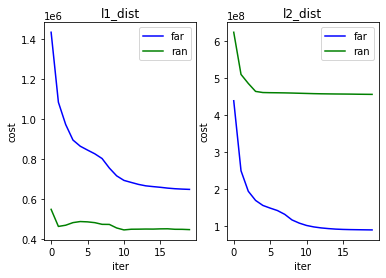

In [10]:
MAX_ITER = 20
for j, dist_fn in enumerate([l1_dist, l2_dist]):
    pylab.subplot(1, 2, j+1)
    pylab.xlabel('iter')
    pylab.ylabel('cost')
    pylab.title(dist_fn.__name__)
    far_cost_seq = []
    ran_cost_seq = []
    far_centroids = sc.broadcast(far_initial_centroids)
    ran_centroids = sc.broadcast(ran_initial_centroids)
    for i in range(MAX_ITER):
        # (cluster, point, min_dist)
        far_assignment = data.map(lambda point: assign_to_cluster(point, far_centroids, dist_fn))
        ran_assignment = data.map(lambda point: assign_to_cluster(point, ran_centroids, dist_fn))
        
        far_cost = sum(far_assignment.map(lambda pc:pc[2]).collect())
        ran_cost = sum(ran_assignment.map(lambda pc:pc[2]).collect())
        print(f'far iter {i}: cost is {far_cost}')
        print(f'ran iter {i}: cost is {ran_cost}')
        far_cost_seq.append(far_cost)
        ran_cost_seq.append(ran_cost)

        new_far_centroids = far_assignment.map(lambda pc:(pc[0],(pc[1],1)))\
                                        .reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1]))\
                                        .mapValues(lambda pc:pc[0]/pc[1])\
                                        .map(lambda pc:pc[1])\
                                        .collect()

        new_ran_centroids = ran_assignment.map(lambda pc:(pc[0],(pc[1],1)))\
                                        .reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1]))\
                                        .mapValues(lambda pc:pc[0]/pc[1])\
                                        .map(lambda pc:pc[1])\
                                        .collect()

        ran_centroids = sc.broadcast(new_ran_centroids)
        far_centroids = sc.broadcast(new_far_centroids)
    pylab.plot(range(MAX_ITER), far_cost_seq, 'b-', label='far')
    pylab.plot(range(MAX_ITER), ran_cost_seq, 'g-', label='ran')
    pylab.legend()
    
pylab.show()